In [154]:
#Si queremos que las imágenes sean mostradas en una ventana emergente quitar el inline
# %matplotlib inline
%matplotlib inline

# OpenCV-Python utiliza NumPy para el manejo de imágenes
import numpy as np
# cv2 es el módulo python para acceder a OpenCV 
import cv2 as cv
# Usamos las poderosas herramientas de graficación de matplotlib para mostrar imágenes, perfiles, histogramas, etc
import matplotlib.pyplot as plt
#Usamos también las poderosas herramientas de procesamiento de imágenes en python de Scikit
from skimage.util import random_noise
from scipy import signal
import scipy.stats as st
import math

In [122]:
def get_gauss_kernel(size=3,sigma=1):
    center=(int)(size/2)
    kernel=np.zeros((size,size))
    for i in range(size):
       for j in range(size):
          diff=np.sqrt((i-center)**2+(j-center)**2)
          kernel[i,j]=np.exp(-(diff**2)/(2*sigma**2))
    return kernel/np.sum(kernel)

In [123]:
def get_gauss_kernel_hp(size=3,sigma=1):
    center=(int)(size/2)
    kernel=np.zeros((size,size))
    for i in range(size):
       for j in range(size):
          diff=np.sqrt((i-center)**2+(j-center)**2)
          kernel[i,j]=np.exp(-(diff**2)/(2*sigma**2))

    kernel = np.sum(kernel)/kernel
    return kernel / np.sum(kernel)

[[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]


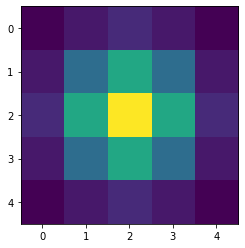

[[0.15004571 0.03347972 0.02030648 0.03347972 0.15004571]
 [0.03347972 0.00747034 0.00453099 0.00747034 0.03347972]
 [0.02030648 0.00453099 0.00274818 0.00453099 0.02030648]
 [0.03347972 0.00747034 0.00453099 0.00747034 0.03347972]
 [0.15004571 0.03347972 0.02030648 0.03347972 0.15004571]]


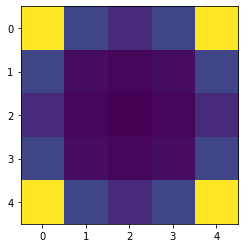

In [124]:
lp = get_gauss_kernel(5,1)

print(lp)
plt.imshow(lp)
plt.show()

hp = get_gauss_kernel_hp(5,1)

print(hp)
plt.imshow(hp)
plt.show()

In [125]:
def create_gauss_filter(h, w, k_size=15, sigma=5):
    filter = get_gauss_kernel(k_size, sigma)
    output = np.zeros((h,w))
    output[int(h/2):int(h/2) + k_size, int(w/2):int(w/2) + k_size] = filter

    return output, np.fft.fft2(output)

kernel


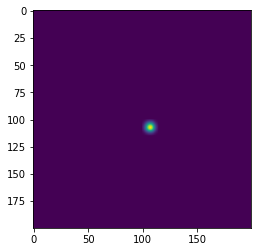

fft kernel


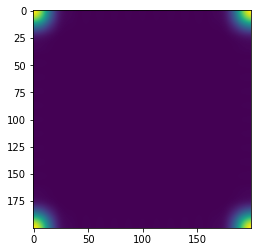

In [126]:
kernel, kernel_tf = create_gauss_filter(200, 200, k_size=15, sigma=3)
print("kernel")
plt.imshow(kernel)
plt.show()
print("fft kernel")
plt.imshow(abs(np.fft.fft2(kernel)))
plt.show()


In [127]:
def create_gauss_filter_hp(h, w, k_size=15, sigma=5):
    filter = get_gauss_kernel_hp(k_size, sigma)
    output = np.zeros((h,w))
    output[int(h/2):int(h/2) + k_size, int(w/2):int(w/2) + k_size] = filter

    return output, np.fft.fft2(output)

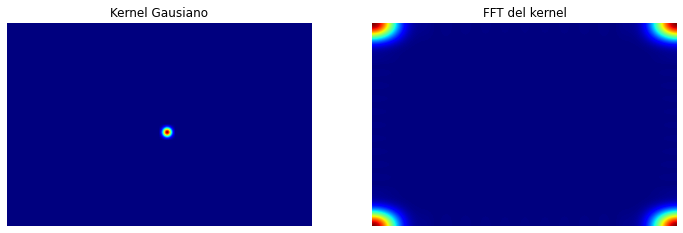

In [128]:
kernel, kernel_tf = create_gauss_filter(200, 300, k_size=15, sigma=3)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.axis('off')
plt.title("Kernel Gausiano")
plt.imshow(kernel, cmap='jet')
plt.subplot(1,2,2)
plt.axis('off')
plt.title("FFT del kernel")
plt.imshow(np.abs(kernel_tf), cmap='jet')
plt.show()

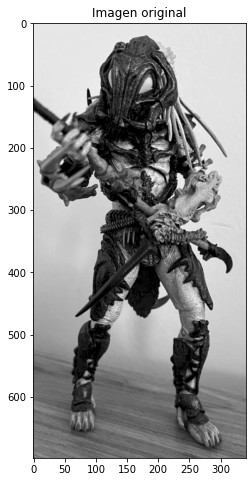

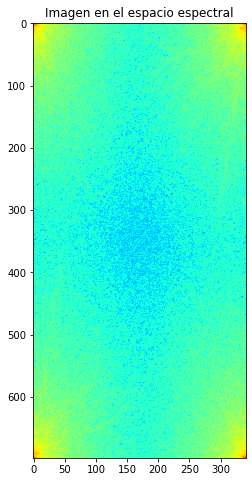

In [137]:
img = cv.imread('fft_alfa_pred.png', cv.IMREAD_GRAYSCALE)

img_fft = np.fft.fft2(img)
plt.figure(figsize=(8,8))
plt.imshow(img, cmap='gray')
plt.title('Imagen original')
plt.show()

plt.figure(figsize=(8,8))
plt.imshow(20*np.log(np.abs(img_fft)), cmap='jet')
plt.title('Imagen en el espacio espectral')
plt.show()

k_size: 5 - sigma: 3


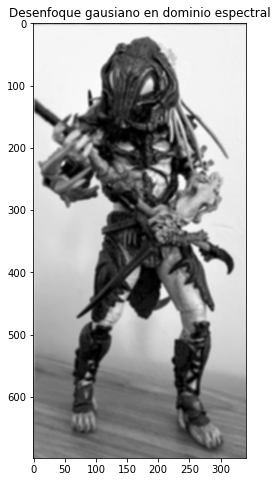

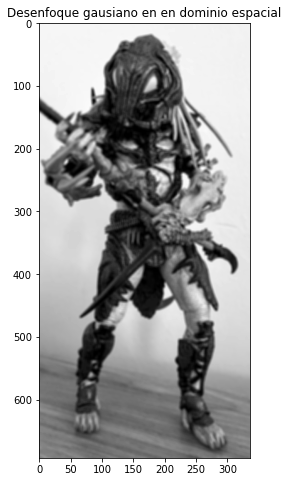

k_size: 5 - sigma: 5


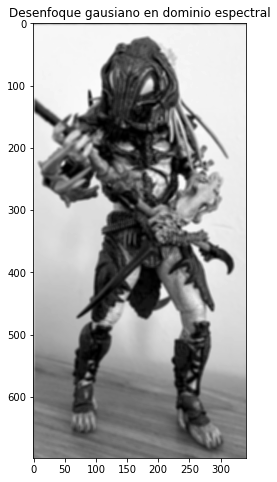

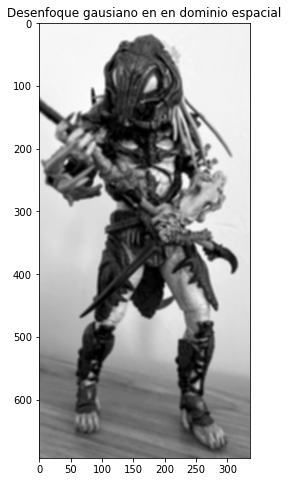

k_size: 15 - sigma: 3


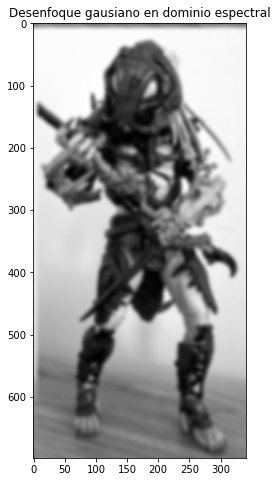

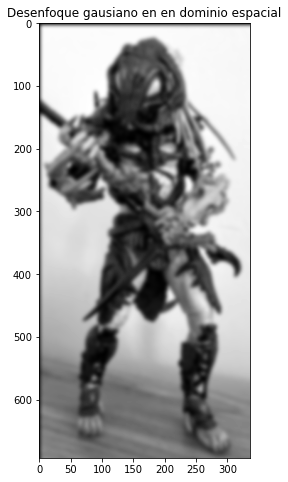

k_size: 15 - sigma: 5


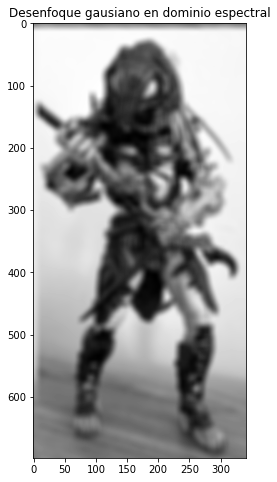

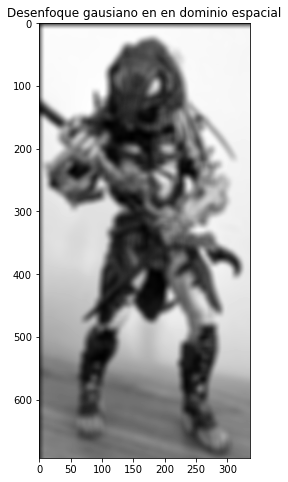

k_size: 21 - sigma: 3


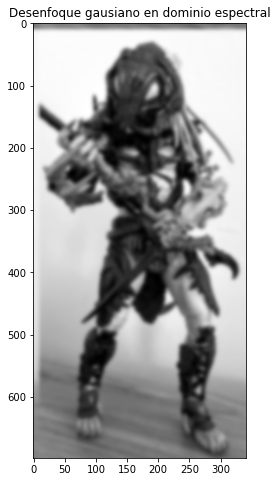

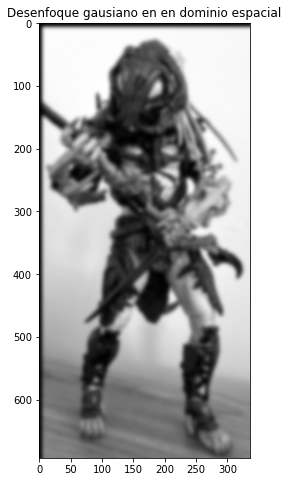

k_size: 21 - sigma: 5


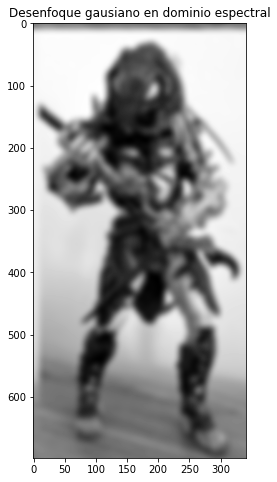

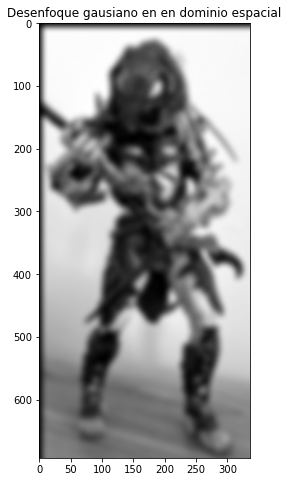

In [140]:
for k_size in [5, 15, 21]:
    for sigma in [3,5]:
        kernel, kernel_tf = create_gauss_filter(img.shape[0], img.shape[1], k_size=k_size, sigma=sigma)
        print("k_size: " + str(k_size) + " - sigma: " + str(sigma))
        filtered = img_fft * kernel_tf

        #img_gauss_spacial = np.real(np.fft.ifft2(np.fft.ifftshift(filtered)))
        spacial = signal.fftconvolve(img, kernel, mode='same')

        img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

        plt.figure(figsize=(8,8))
        plt.imshow(img_gauss, cmap='gray')
        plt.title('Desenfoque gausiano en dominio espectral')
        plt.show()

        plt.figure(figsize=(8,8))
        plt.imshow(spacial[5:,5:], cmap='gray')
        plt.title('Desenfoque gausiano en en dominio espacial')
        plt.show()

Vemos que el filtro en el dominio espacial mediante convolución es análogo al filtro en el dominio espectral (https://dsp.stackexchange.com/questions/74358/spatial-domain-vs-frequency-domain-filtering-of-an-image-which-one-is-better). En el dominio espectral se pueden obtener resultados con mayor eficiencia computacional.


Cuando comparamos sigma y k_size, vemos que a medida que aumenta el tamaño del kernel se pierden mas fácil los detalles en bordes, y a medida que aumenta el sigma aumenta aún mas notoriamente el difuminado

In [130]:
def freq(collection):
    d = {}
    max_freq_index = -1
    max_freq = -1

    for i in collection.flatten():
        if d.get(i):
            d[i] += 1
        else:
            d[i] = 1
        
        if d[i] > max_freq:
            max_freq = d[i]
            max_freq_index = i
            
    return max_freq_index

Link to paper: https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/vision_computadora_I/blob/7ma-cohorte/Articulos/ImageSharpnessMeasureforBlurredImagesinFrequency.pdf

In [148]:
def quality_measure(img):
    F = np.fft.fft2(img)
    FC = np.fft.ifftshift(F)
    AF = np.abs(FC)
    m = freq(AF)
    thres = m/1000
    th = len([x for x in F.flatten() if x > thres])
    img_shape = img.shape

    quality_measure = th / (img_shape[0] * img_shape[1])

    return quality_measure


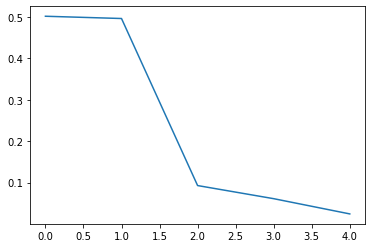

In [149]:
measures = []
img = cv.imread('fft_alfa_pred.png', cv.IMREAD_GRAYSCALE)
measures.append(quality_measure(img))



for sigma_i in [0.5,2.5,5,7.5]:
    kernel, kernel_tf = create_gauss_filter(img.shape[0], img.shape[1], k_size=5, sigma=sigma_i)

    img_fft = np.fft.fft2(img)
    filtered = img_fft * kernel_tf
    img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))
    
    measures.append(quality_measure(img_gauss))


plt.plot(measures)


Dada esta métrica de calidad, notamos como a medida que aumenta el sigma aumenta el difuminado de la imagen, y podemos ver como desciende la métrica de calidad de la misma, por lo que el resultado es consistente

Link to paper: https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/vision_computadora_I/blob/7ma-cohorte/Articulos/AnalysisOfFocusMeasureOperators.pdf Measure A.3. Image Contrast (MIS3)

In [150]:
def valid_index(img, i, j):
    return not(i < 0 or j < 0 or i >= img.shape[0] or j >= img.shape[1])
    
def image_contrast_measure(img):
    coeficients = np.zeros(img.shape)
    
    for x in range(0, coeficients.shape[0]):
        for y in range(0, coeficients.shape[1]):
            for i in [x-1, x, x+1]:
                for j in [y-1, y, y+1]:
                    I_i_j = img[i][j] if valid_index(img, i, j) else 0
                    coeficients[x][y] = np.abs(img[x][y] - I_i_j)

    measure = 0
    for x in range(0, coeficients.shape[0]):
        for y in range(0, coeficients.shape[1]):
            measure = measure + coeficients[x][y]

    return measure

/var/folders/s5/5nbwzy4127vdzvv2wpcsr6hj4mpngl/T/ipykernel_71374/3648720879.py:12: RuntimeWarning: overflow encountered in ubyte_scalars
  coeficients[x][y] = np.abs(img[x][y] - I_i_j)


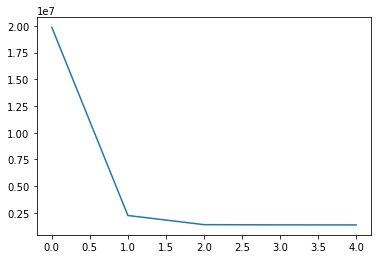

In [151]:
measures = []
img = cv.imread('fft_alfa_pred.png', cv.IMREAD_GRAYSCALE)
measures.append(image_contrast_measure(img))



for sigma_i in [0.5,2.5,5,7.5]:
    kernel, kernel_tf = create_gauss_filter(img.shape[0], img.shape[1], k_size=5, sigma=sigma_i)

    img_fft = np.fft.fft2(img)
    filtered = img_fft * kernel_tf
    img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))
    measures.append(image_contrast_measure(img_gauss))


plt.plot(measures)

En este caso vemos un comportamiento similar, a medida que aumenta el sigma aumenta el difuminado de la imagen, y podemos ver como desciende la métrica de calidad de la misma. Al final este descenso parece asintótico, pero se nota un gran descenso en los primeros aumentos de sigma, representando que la imagen perdió calidad, lo que es consistente con el hecho de que la misma se difumina mas al aumentar sigma

Comparamos ambas métricas

/var/folders/s5/5nbwzy4127vdzvv2wpcsr6hj4mpngl/T/ipykernel_71374/3648720879.py:12: RuntimeWarning: overflow encountered in ubyte_scalars
  coeficients[x][y] = np.abs(img[x][y] - I_i_j)


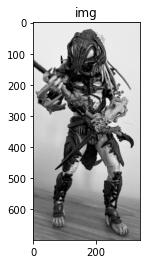

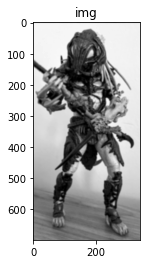

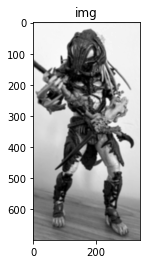

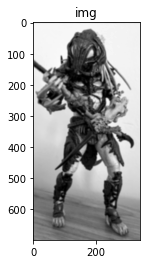

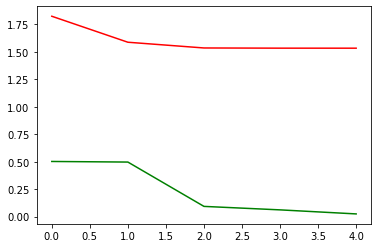

In [157]:
sharpness_measures = []
image_contrast_measures = []
img = cv.imread('fft_alfa_pred.png', cv.IMREAD_GRAYSCALE)
sharpness_measures.append(quality_measure(img))
image_contrast_measures.append((1/4) * math.log10(image_contrast_measure(img)))



for sigma_i in [0.5,2.5,5,7.5]:
    kernel, kernel_tf = create_gauss_filter(img.shape[0], img.shape[1], k_size=5, sigma=sigma_i)

    img_fft = np.fft.fft2(img)
    filtered = img_fft * kernel_tf
    img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

    plt.imshow(img_gauss, cmap='gray')
    plt.title('img')
    plt.show()
    sharpness_measures.append(quality_measure(img_gauss.copy()))
    image_contrast_measures.append((1/4) * math.log10(image_contrast_measure(img_gauss.copy())))


plt.plot(sharpness_measures, 'g')
plt.plot(image_contrast_measures, 'r')


Vemos en rojo la métrica image_contrast y en verde la de sharpness mesure, y vemos imagen a imagen como se va difuminando. En ambos casos se ve como el valor obtenido por cada métrica desciende. Tuve que ajustar la escala ya que el caso de image_contrast retorna un valor mucho mas alto que la de sharpness, por lo que le aplique un factor (lo mapee a 1/4 de su log10) para poder comparar. 

Image_contrast muestra un descenso mas rápido en los primeros aumentos de sigma y despues el descenso se da mucho mas lento, mientras que la métrica de sharpness tiene un descenso mas pronunciado para sigma entre 1 y 2, luego tambien desacelera su descenso.